# Portfolio Weights: Understanding Your Allocation

**Time:** 12 minutes

**Prerequisites:** 01_stock_basics.ipynb, 02_position_and_portfolio_value.ipynb

---

Knowing the dollar value of each position is useful, but **weights** tell you something more important: how concentrated or diversified your portfolio is. This is critical for risk management.

## What Are Portfolio Weights?

A **portfolio weight** is the percentage of your total portfolio that one position represents.

**Weight Formula:**

$$\text{Weight}_i = \frac{\text{Position Value}_i}{\text{Total Portfolio Value}} \times 100\%$$

**Example:**
- Your AAPL position is worth \\$17,500
- Your total portfolio is worth \\$87,500
- AAPL's weight =\\$17,500 ÷ \\$87,500 × 100 = 20%

**Mental Model: The Pie Chart**

Think of your portfolio as a pie. Each slice (position) has a certain size relative to the whole pie. Weights tell you how big each slice is.

In [ ]:
# Install required packages
!pip install -q yfinance pandas matplotlib

In [ ]:
import yfinance as yf
import pandas as pd

def get_price(ticker):
    """Get current price for a ticker."""
    stock = yf.Ticker(ticker)
    info = stock.info
    return info.get('currentPrice') or info.get('regularMarketPrice') or info.get('previousClose')

def calculate_portfolio_weights(holdings):
    """Calculate the weight of each position in a portfolio.

    Args:
        holdings: Dictionary of {ticker: shares}

    Returns:
        DataFrame with positions, values, and weights
    """
    positions = []

    for ticker, shares in holdings.items():
        price = get_price(ticker)
        value = shares * price
        positions.append({
            'ticker': ticker,
            'shares': shares,
            'price': price,
            'value': value
        })

    # Convert to DataFrame
    df = pd.DataFrame(positions)

    # Calculate weights
    total_value = df['value'].sum()
    df['weight'] = (df['value'] / total_value) * 100

    # Sort by weight (largest first)
    df = df.sort_values('weight', ascending=False).reset_index(drop=True)

    return df, total_value

# Define sample portfolio
my_portfolio = {
    'AAPL': 100,
    'NVDA': 50,
    'MSFT': 75,
    'GOOGL': 30,
    'AMZN': 25
}

# Calculate weights
df, total = calculate_portfolio_weights(my_portfolio)

print("Portfolio Weights Analysis")
print("=" * 65)
print(f"{'Ticker':<8} {'Shares':>10} {'Price':>12} {'Value':>14} {'Weight':>12}")
print("-" * 65)

for _, row in df.iterrows():
    print(f"{row['ticker']:<8} {row['shares']:>10,} ${row['price']:>10,.2f} ${row['value']:>12,.2f} {row['weight']:>10.1f}%")

print("-" * 65)
print(f"{'TOTAL':<8} {'':<10} {'':<12} ${total:>12,.2f} {100.0:>10.1f}%")

Portfolio Weights Analysis
Ticker       Shares        Price          Value       Weight
-----------------------------------------------------------------
MSFT             75 $    446.72 $   33,504.00       40.1%
AAPL            100 $    249.76 $   24,976.00       29.9%
GOOGL            30 $    331.16 $    9,934.80       11.9%
NVDA             50 $    184.79 $    9,239.75       11.1%
AMZN             25 $    233.55 $    5,838.75        7.0%
-----------------------------------------------------------------
TOTAL                            $   83,493.30      100.0%


## Visualizing Portfolio Weights

A pie chart is often villified as a chart, but it's the classic way to visualize portfolio allocation.

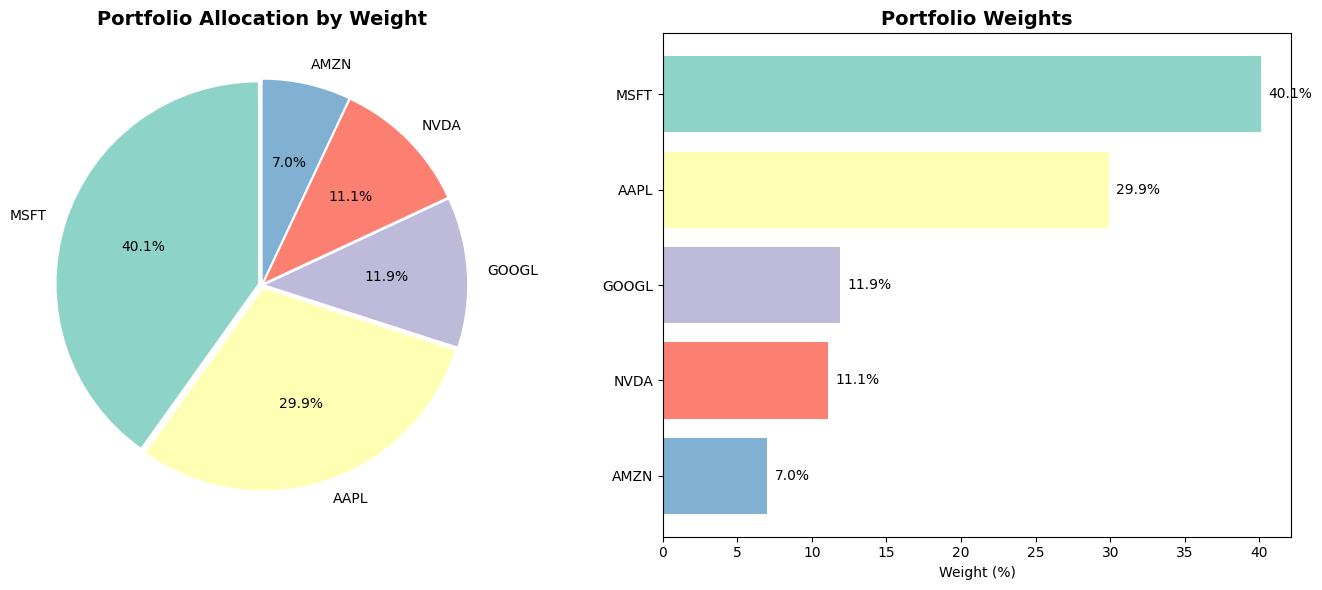

In [ ]:
import matplotlib.pyplot as plt

# Create pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
colors = plt.cm.Set3(range(len(df)))
explode = [0.02] * len(df)  # slight separation

ax1.pie(df['weight'], labels=df['ticker'], autopct='%1.1f%%',
        colors=colors, explode=explode, startangle=90)
ax1.set_title('Portfolio Allocation by Weight', fontsize=14, fontweight='bold')

# Bar chart
bars = ax2.barh(df['ticker'], df['weight'], color=colors)
ax2.set_xlabel('Weight (%)')
ax2.set_title('Portfolio Weights', fontsize=14, fontweight='bold')
ax2.invert_yaxis()  # Largest at top

# Add value labels on bars
for bar, weight in zip(bars, df['weight']):
    ax2.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             f'{weight:.1f}%', va='center')

plt.tight_layout()
plt.show()

## Why Weights Matter: Concentration Risk

**Concentration Risk:** When too much of your portfolio is in one position.

**Example Scenarios:**

| Scenario | NVDA Weight | If NVDA drops 20%... |
|----------|-------------|----------------------|
| Concentrated | 60% | Portfolio loses 12% |
| Balanced | 20% | Portfolio loses 4% |
| Diversified | 10% | Portfolio loses 2% |


**The Math:**
$$\text{Portfolio Impact} = \text{Position Weight} \times \text{Position Return}$$

In [ ]:
def analyze_concentration_risk(df, threshold=10):
    """Analyze concentration risk in portfolio.

    Args:
        df: DataFrame with 'ticker' and 'weight' columns
        threshold: Weight percentage above which a position is "concentrated"
    """
    print("Concentration Risk Analysis")
    print("=" * 50)

    # Find concentrated positions
    concentrated = df[df['weight'] > threshold]

    if len(concentrated) > 0:
        print(f"\nPositions above {threshold}% threshold:")
        for _, row in concentrated.iterrows():
            print(f"  {row['ticker']}: {row['weight']:.1f}%")
            # Calculate impact of 20% drop
            impact = row['weight'] * 0.20
            print(f"    → If it drops 20%, portfolio loses {impact:.1f}%")
    else:
        print(f"\nNo positions above {threshold}% threshold. Portfolio looks diversified!")

    # Top 3 holdings concentration
    top3_weight = df.head(3)['weight'].sum()
    print(f"\nTop 3 holdings: {top3_weight:.1f}% of portfolio")
    if top3_weight > 50:
        print("  → HIGH concentration in top holdings")
    elif top3_weight > 30:
        print("  → MODERATE concentration")
    else:
        print("  → Well diversified across holdings")

# Analyze our portfolio
analyze_concentration_risk(df, threshold=15)

Concentration Risk Analysis

Positions above 15% threshold:
  MSFT: 40.1%
    → If it drops 20%, portfolio loses 8.0%
  AAPL: 29.9%
    → If it drops 20%, portfolio loses 6.0%

Top 3 holdings: 81.9% of portfolio
  → HIGH concentration in top holdings


## Impact Analysis: What If Scenarios

Understanding weights helps you answer questions like:
- "If NVDA drops 15%, how much does my portfolio lose?"
- "Which position affects my portfolio the most?"

In [ ]:
def what_if_analysis(df, ticker, percent_change):
    """Calculate portfolio impact of a position's price change.

    Args:
        df: Portfolio DataFrame with weights
        ticker: Stock to analyze
        percent_change: Price change (e.g., -15 for 15% drop)
    """
    row = df[df['ticker'] == ticker]
    if len(row) == 0:
        print(f"{ticker} not found in portfolio")
        return

    weight = row['weight'].values[0]
    portfolio_impact = weight * (percent_change / 100)

    print(f"What-If Analysis: {ticker} {percent_change:+.0f}%")
    print("-" * 40)
    print(f"Position weight:    {weight:.1f}%")
    print(f"Position change:    {percent_change:+.1f}%")
    print(f"Portfolio impact:   {portfolio_impact:+.2f}%")
    print(f"\nFormula: {weight:.1f}% × {percent_change:.1f}% = {portfolio_impact:.2f}%")

# Examples
print("Scenario 1: Your biggest position drops 20%\n")
biggest = df.iloc[0]['ticker']
what_if_analysis(df, biggest, -20)

print("\n" + "="*50 + "\n")

print("Scenario 2: Your smallest position rallies 30%\n")
smallest = df.iloc[-1]['ticker']
what_if_analysis(df, smallest, 30)

Scenario 1: Your biggest position drops 20%

What-If Analysis: MSFT -20%
----------------------------------------
Position weight:    40.1%
Position change:    -20.0%
Portfolio impact:   -8.03%

Formula: 40.1% × -20.0% = -8.03%


Scenario 2: Your smallest position rallies 30%

What-If Analysis: AMZN +30%
----------------------------------------
Position weight:    7.0%
Position change:    +30.0%
Portfolio impact:   +2.10%

Formula: 7.0% × 30.0% = 2.10%


## Equal Weight vs. Market Cap Weight

Two common approaches to portfolio construction:

### 1. Equal Weight
Every position has the same dollar value (and thus same weight).

**Example (5 stocks):** Each position = 20%

**Pros:**
- Simple to understand and maintain
- No single stock dominates
- Equal exposure to each company

**Cons:**
- Requires frequent rebalancing
- May give too much weight to small/risky companies

### 2. Market Cap Weight
Weights match company size (bigger companies = bigger weights).

**Example:** Apple (huge) might be 25%, a smaller company might be 5%

**Pros:**
- Self-rebalancing (winners grow automatically)
- Reflects market's view of company value

**Cons:**
- Concentrated in mega-caps
- You "chase momentum" (buy high, sell low)

In [ ]:
def create_equal_weight_portfolio(tickers, total_capital):
    """Calculate equal-weight positions for given capital.

    Args:
        tickers: List of stock symbols
        total_capital: Total dollars to invest
    """
    n = len(tickers)
    capital_per_stock = total_capital / n
    target_weight = 100 / n

    positions = []
    for ticker in tickers:
        price = get_price(ticker)
        shares = int(capital_per_stock / price)
        actual_value = shares * price

        positions.append({
            'ticker': ticker,
            'price': price,
            'shares': shares,
            'value': actual_value
        })

    df = pd.DataFrame(positions)
    df['actual_weight'] = (df['value'] / df['value'].sum()) * 100
    df['target_weight'] = target_weight

    return df

# Create equal-weight portfolio with $50,000
tickers = ["AAPL", "NVDA", "MSFT", "GOOGL", "AMZN"]
equal_df = create_equal_weight_portfolio(tickers, 50000)

print("Equal Weight Portfolio ($50,000)")
print("=" * 70)
print(f"Target: {100/len(tickers):.1f}% per position")
print("-" * 70)
print(f"{'Ticker':<8} {'Price':>10} {'Shares':>10} {'Value':>12} {'Actual':>10} {'Target':>10}")
print("-" * 70)

for _, row in equal_df.iterrows():
    print(f"{row['ticker']:<8} ${row['price']:>8,.2f} {row['shares']:>10} ${row['value']:>10,.2f} {row['actual_weight']:>9.1f}% {row['target_weight']:>9.1f}%")

print("-" * 70)
print(f"{'TOTAL':<8} {'':<10} {'':<10} ${equal_df['value'].sum():>10,.2f}")

Equal Weight Portfolio ($50,000)
Target: 20.0% per position
----------------------------------------------------------------------
Ticker        Price     Shares        Value     Actual     Target
----------------------------------------------------------------------
AAPL     $  249.73         40 $  9,989.20      20.2%      20.0%
NVDA     $  184.91         54 $  9,985.14      20.1%      20.0%
MSFT     $  446.92         22 $  9,832.24      19.8%      20.0%
GOOGL    $  331.05         30 $  9,931.50      20.0%      20.0%
AMZN     $  234.13         42 $  9,833.46      19.8%      20.0%
----------------------------------------------------------------------
TOTAL                          $ 49,571.54


## Weight Drift: Why Rebalancing Matters

Over time, as prices change, your weights **drift** away from your targets.

**Example:**
- You start with 5 equal positions (20% each)
- One stock doubles while others stay flat
- Now it's ~33% of your portfolio!

This is called **weight drift** and it's why portfolios need periodic **rebalancing**.

In [ ]:
def simulate_weight_drift(initial_weights, returns):
    """Simulate how weights change after returns.

    Args:
        initial_weights: Dict of {ticker: weight}
        returns: Dict of {ticker: return_pct}
    """
    # Calculate new values (assume $10,000 starting)
    initial_total = 10000

    results = []
    for ticker, weight in initial_weights.items():
        initial_value = initial_total * (weight / 100)
        ret = returns.get(ticker, 0) / 100
        new_value = initial_value * (1 + ret)
        results.append({
            'ticker': ticker,
            'initial_weight': weight,
            'return': returns.get(ticker, 0),
            'initial_value': initial_value,
            'new_value': new_value
        })

    df = pd.DataFrame(results)
    new_total = df['new_value'].sum()
    df['new_weight'] = (df['new_value'] / new_total) * 100
    df['weight_drift'] = df['new_weight'] - df['initial_weight']

    return df, new_total

# Scenario: Start equal, one stock skyrockets
initial = {'AAPL': 20, 'NVDA': 20, 'MSFT': 20, 'GOOGL': 20, 'AMZN': 20}
returns = {'AAPL': 5, 'NVDA': 100, 'MSFT': 10, 'GOOGL': -5, 'AMZN': 15}  # NVDA doubles!

drift_df, new_total = simulate_weight_drift(initial, returns)

print("Weight Drift Simulation")
print("=" * 75)
print(f"Scenario: NVDA doubles (+100%), others have modest returns")
print("-" * 75)
print(f"{'Ticker':<8} {'Return':>10} {'Initial Wt':>12} {'New Weight':>12} {'Drift':>12}")
print("-" * 75)

for _, row in drift_df.iterrows():
    print(f"{row['ticker']:<8} {row['return']:>+9.0f}% {row['initial_weight']:>11.1f}% {row['new_weight']:>11.1f}% {row['weight_drift']:>+11.1f}%")

print("-" * 75)
print(f"\nNVDA went from 20% to {drift_df[drift_df['ticker']=='NVDA']['new_weight'].values[0]:.1f}%!")
print("This concentration increases your risk to NVDA.")

Weight Drift Simulation
Scenario: NVDA doubles (+100%), others have modest returns
---------------------------------------------------------------------------
Ticker       Return   Initial Wt   New Weight        Drift
---------------------------------------------------------------------------
AAPL            +5%        20.0%        16.8%        -3.2%
NVDA          +100%        20.0%        32.0%       +12.0%
MSFT           +10%        20.0%        17.6%        -2.4%
GOOGL           -5%        20.0%        15.2%        -4.8%
AMZN           +15%        20.0%        18.4%        -1.6%
---------------------------------------------------------------------------

NVDA went from 20% to 32.0%!
This concentration increases your risk to NVDA.


## Key Takeaways

### Formulas You've Learned:

1. **Position Weight** = Position Value ÷ Total Portfolio Value × 100%

2. **Portfolio Impact** = Position Weight × Position Return

3. **Weight Drift** = Current Weight - Target Weight

### Key Concepts:

- **Concentration Risk:** Too much in one position amplifies gains AND losses
- **Equal Weight:** Same dollar amount in each position (20% each for 5 stocks)
- **Market Cap Weight:** Bigger companies get bigger allocations
- **Weight Drift:** Weights change as prices change, requiring rebalancing

### Why This Matters for AI Agents:

When we build AI agents, they'll need to:
- Calculate current portfolio weights
- Identify concentration risks
- Suggest rebalancing trades
- Analyze "what if" scenarios

**Next Notebook:** We'll learn about returns and performance measurement.